In [2]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from pymanticore.analysis.matplotlib import get_mplstyle_path, ManticoreColors
import sys

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

from backend.config_loader import load_config
from backend.utils import *

In [8]:
# Cell 2: Configuration Loading
config = load_config(config_path="../config.toml")

print("Configuration loaded:")
print(f"Base directory: {config.global_config.basedir}")
print(f"Output directory: {config.global_config.output_dir}")
print(f"Observer coordinates: {config.global_config.observer_coords}")
print(f"Mode1 - eps: {config.mode1.eps}, min_samples: {config.mode1.min_samples}")
print(f"Mode2 - target_snapshot: {config.mode2.target_snapshot}, min_cluster_size: {config.mode2.min_cluster_size}")

mnras_style = "mnras"

OUTPUT_DIR = os.path.join("..", config.global_config.output_dir)
MIN_CLUSTER_SIZE = config.mode2.min_cluster_size

Configuration loaded:
Base directory: /cosma7/data/dp004/rttw52/manticore_data/production_runs/v2b/resimulations/2MPP_MULTIBIN_N256_DES_V2/R1024
Output directory: output
Observer coordinates: [500.0, 500.0, 500.0]
Mode1 - eps: 1.75, min_samples: 9
Mode2 - target_snapshot: 10, min_cluster_size: 40


# Investigate the `eps` and `min_samples` dependence

Load Cluster Data for Different Eps and Min_Samples Values with Position and Mass Std Analysis

In [7]:
# Define parameter ranges
eps_values = [1.5, 1.75, 2.0, 2.5, 3.0, 3.5]
min_samples_values = [5, 7, 9]

# Storage for results
eps_min_samples_results = {}

for min_samples in min_samples_values:
   eps_min_samples_results[min_samples] = {}
   
   for eps in eps_values:
       # Convert eps to filename format (2.5 -> "2p5")
       eps_str = str(eps).replace('.', 'p')
       filename = f"clusters_eps_{eps_str}_min_samples_{min_samples}.h5"
       
       try:
           clusters, cluster_metadata = load_clusters_from_hdf5(OUTPUT_DIR, filename=filename)
           
           # Calculate basic metrics
           n_clusters = len(clusters)
           cluster_sizes = [c['cluster_size'] for c in clusters]
           mean_cluster_size = np.mean(cluster_sizes) if cluster_sizes else 0
           max_cluster_size = max(cluster_sizes) if cluster_sizes else 0
           large_clusters = len([s for s in cluster_sizes if s >= 40])
           
           # Filter to only large clusters (>= 40 members) for std calculations
           large_cluster_data = [c for c in clusters if c['cluster_size'] >= MIN_CLUSTER_SIZE]
           
           # Calculate position std statistics for large clusters only
           position_stds = []
           log_mass_stds = []
           mass_stds = []
           large_cluster_sizes = []
           
           for cluster in large_cluster_data:
               # Position std magnitude (3D vector -> scalar)
               pos_std = cluster.get('position_std', np.array([0, 0, 0]))
               position_stds.append(np.linalg.norm(pos_std))

               # Linear mass std for comparison
               log_mass_stds.append(cluster.get('log10_m200_mass_std', 0))
               mass_stds.append(cluster.get('m200_mass_std', 0))
               large_cluster_sizes.append(cluster['cluster_size'])
           
           # Summary statistics for large clusters only
           mean_position_std = np.mean(position_stds) if position_stds else 0# Cell: 

           mean_log_mass_std = np.mean(log_mass_stds) if log_mass_stds else 0
           mean_mass_std = np.mean(mass_stds) if mass_stds else 0
           
           # Size-weighted statistics for large clusters
           if large_cluster_sizes and position_stds:
               weights = np.array(large_cluster_sizes)
               weighted_mean_position_std = np.average(position_stds, weights=weights)
               weighted_mean_log_mass_std = np.average(log_mass_stds, weights=weights)
           else:
               weighted_mean_position_std = 0
               weighted_mean_log_mass_std = 0
           
           eps_min_samples_results[min_samples][eps] = {
               'n_clusters': n_clusters,
               'mean_size': mean_cluster_size,
               'max_size': max_cluster_size,
               'large_clusters': large_clusters,
               'cluster_sizes': cluster_sizes,
               'mean_position_std': mean_position_std,
               'mean_log_mass_std': mean_log_mass_std,
               'mean_mass_std': mean_mass_std,
               'weighted_mean_position_std': weighted_mean_position_std,
               'weighted_mean_log_mass_std': weighted_mean_log_mass_std,
               'position_stds': position_stds,
               'log_mass_stds': log_mass_stds,
               'mass_stds': mass_stds,
               'n_large_clusters': len(large_cluster_data),
               'clusters': clusters,
               'metadata': cluster_metadata
           }
           
           print(f"min_samples={min_samples}, eps={eps}: {n_clusters} clusters, "
                 f"large={large_clusters}, pos_std={mean_position_std:.2f}, "
                 f"log_mass_std={mean_log_mass_std:.3f}")
           
       except FileNotFoundError:
           print(f"File not found for min_samples={min_samples}, eps={eps}: {filename}")
           eps_min_samples_results[min_samples][eps] = None
       except Exception as e:
           print(f"Error loading min_samples={min_samples}, eps={eps}: {e}")
           eps_min_samples_results[min_samples][eps] = None

File not found for min_samples=5, eps=1.5: clusters_eps_1p5_min_samples_5.h5
File not found for min_samples=5, eps=1.75: clusters_eps_1p75_min_samples_5.h5
File not found for min_samples=5, eps=2.0: clusters_eps_2p0_min_samples_5.h5
File not found for min_samples=5, eps=2.5: clusters_eps_2p5_min_samples_5.h5
File not found for min_samples=5, eps=3.0: clusters_eps_3p0_min_samples_5.h5
File not found for min_samples=5, eps=3.5: clusters_eps_3p5_min_samples_5.h5
min_samples=7, eps=1.5: 765 clusters, large=197, pos_std=2.19, log_mass_std=0.141
min_samples=7, eps=1.75: 943 clusters, large=257, pos_std=2.49, log_mass_std=0.145
min_samples=7, eps=2.0: 1093 clusters, large=299, pos_std=2.85, log_mass_std=0.147
min_samples=7, eps=2.5: 827 clusters, large=202, pos_std=2.55, log_mass_std=0.133
File not found for min_samples=7, eps=3.0: clusters_eps_3p0_min_samples_7.h5
File not found for min_samples=7, eps=3.5: clusters_eps_3p5_min_samples_7.h5
min_samples=9, eps=1.5: 487 clusters, large=177, pos

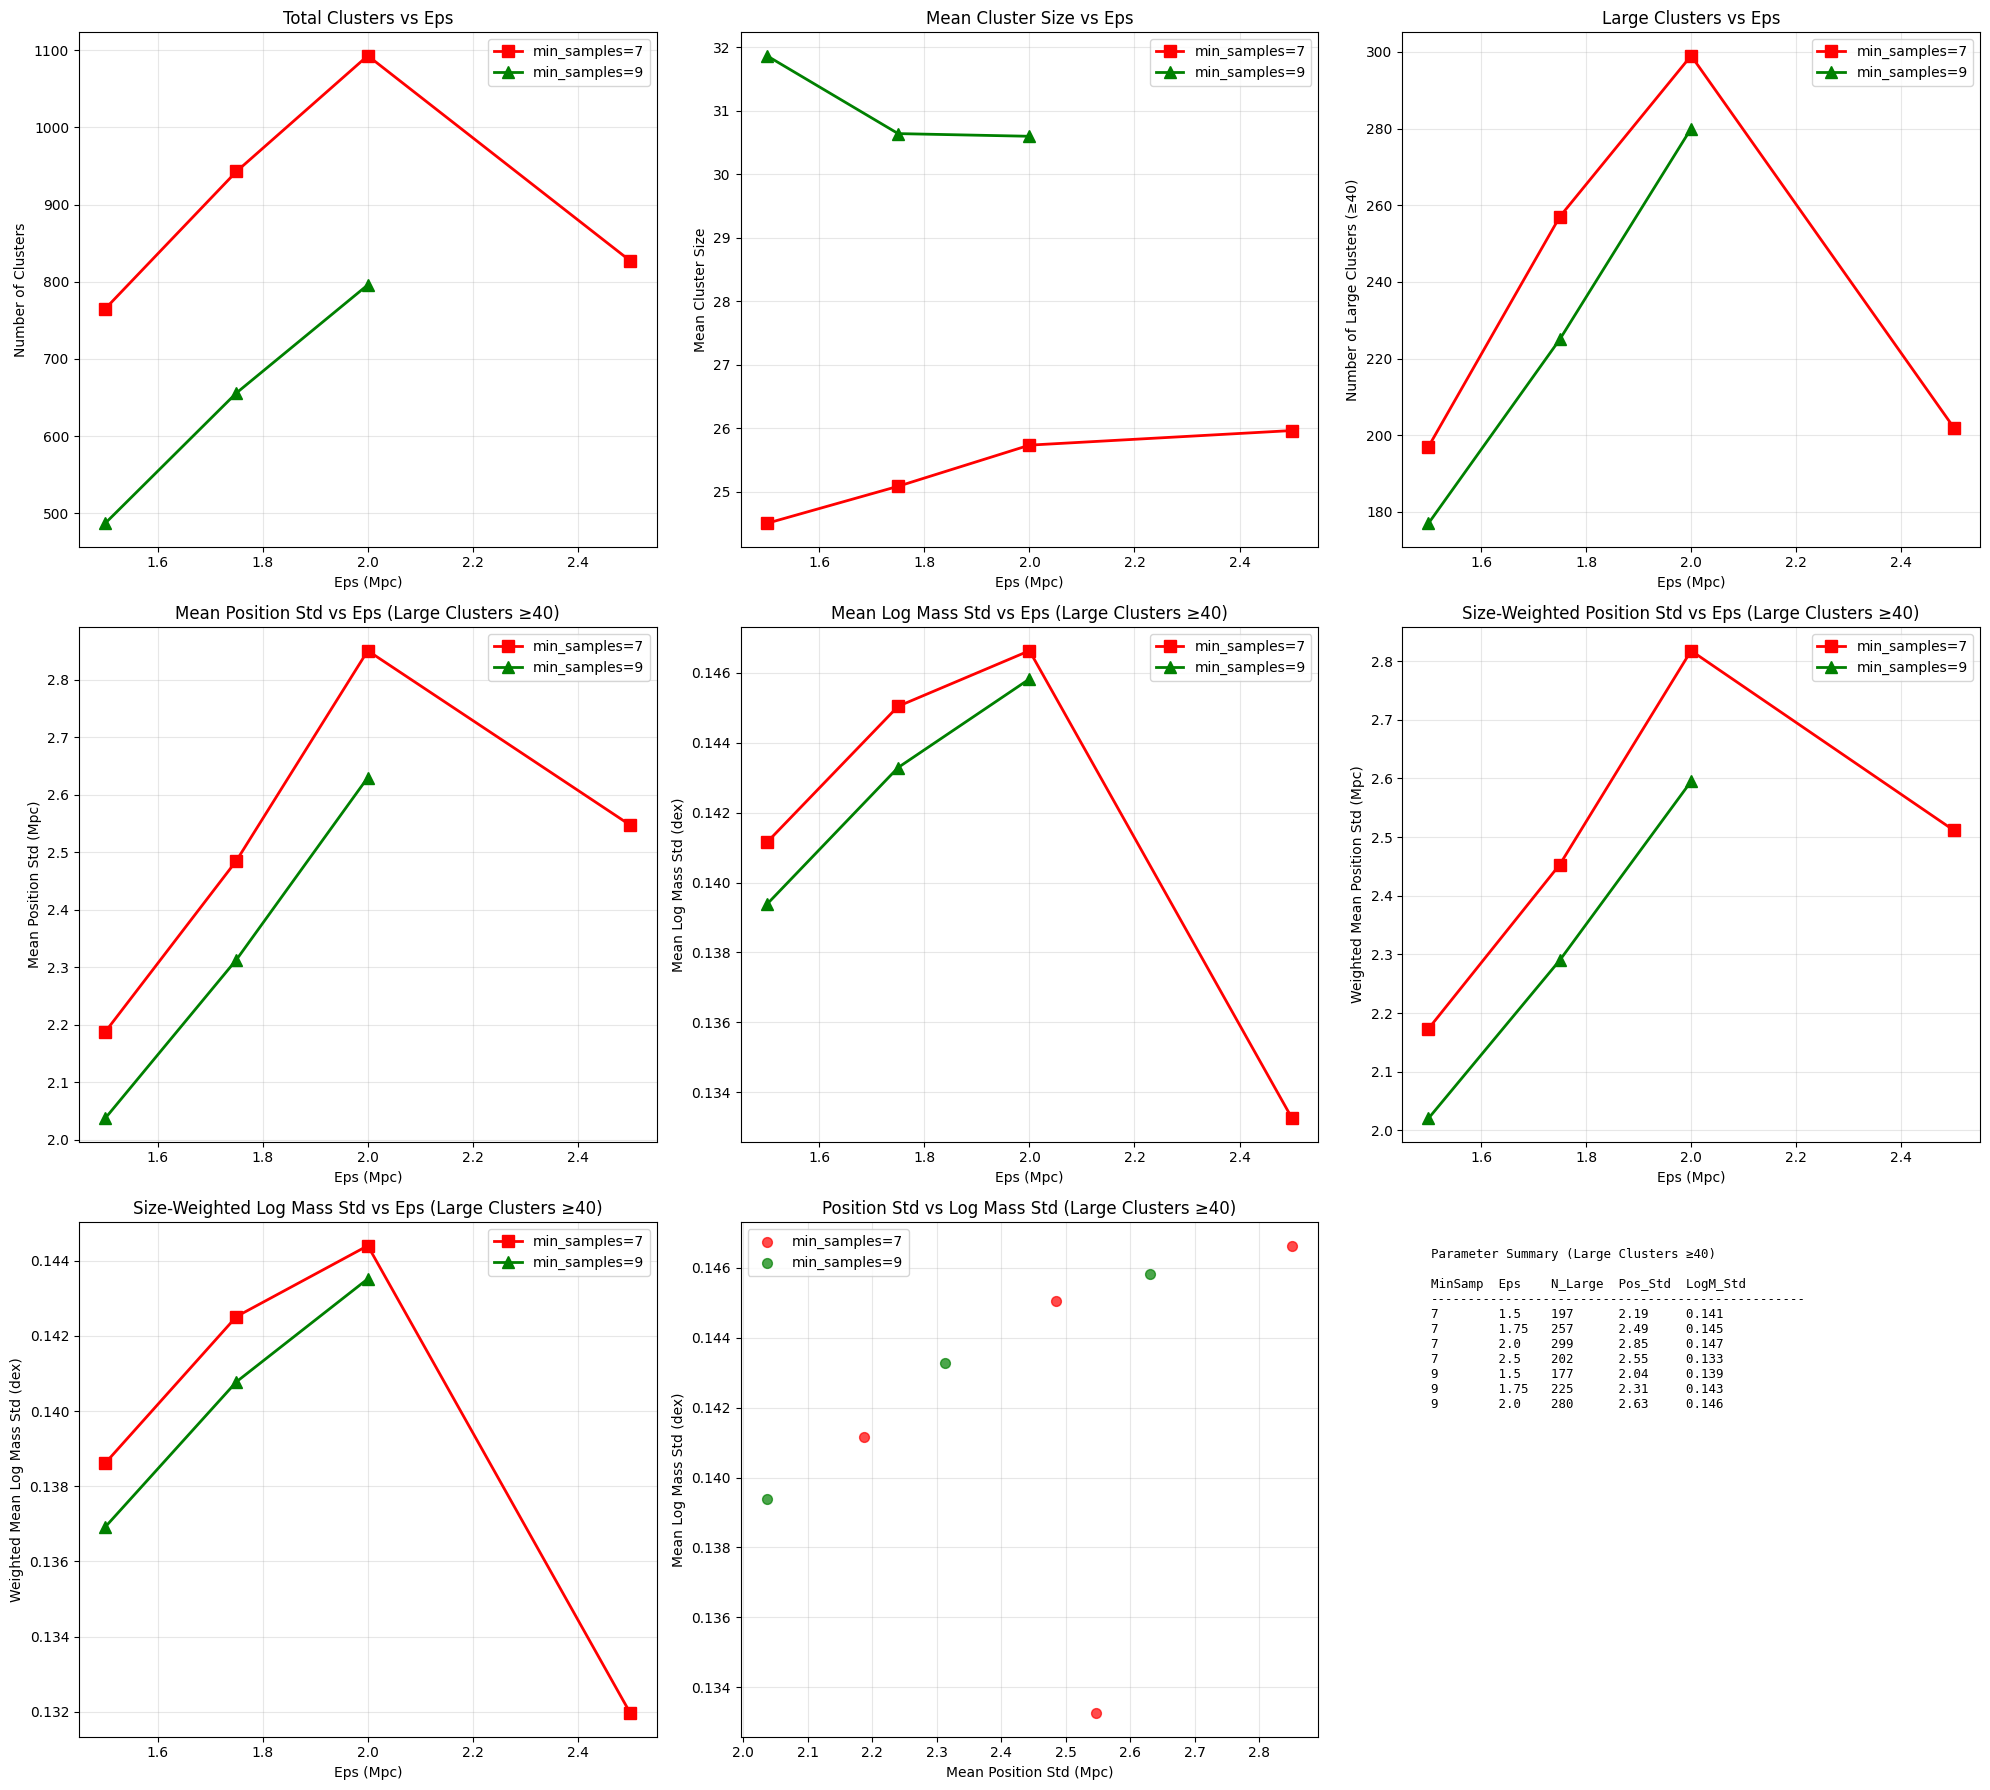


MinSamp  Eps    N_Clust  N_Large  Pos_Std  LogM_Std   Wtd_Pos  Wtd_LogM  
------------------------------------------------------------------------------------------
7        1.5    765      197      2.19     0.141      2.17     0.139     
7        1.75   943      257      2.49     0.145      2.45     0.143     
7        2.0    1093     299      2.85     0.147      2.82     0.144     
7        2.5    827      202      2.55     0.133      2.51     0.132     
9        1.5    487      177      2.04     0.139      2.02     0.137     
9        1.75   656      225      2.31     0.143      2.29     0.141     
9        2.0    796      280      2.63     0.146      2.59     0.144     


In [9]:
# Cell: Enhanced Parameter Analysis Plots Including Position and Mass Std (Large Clusters Only)

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

colors = ['blue', 'red', 'green', 'orange', 'purple']
markers = ['o', 's', '^', 'D', 'v']

# Extract data for all min_samples values
plot_data = {}
for i, min_samples in enumerate(min_samples_values):
    plot_data[min_samples] = {
        'valid_eps': [],
        'n_clusters': [],
        'mean_sizes': [],
        'large_clusters': [],
        'mean_position_stds': [],
        'mean_log_mass_stds': [],
        'weighted_position_stds': [],
        'weighted_log_mass_stds': []
    }
    
    for eps in eps_values:
        if eps_min_samples_results[min_samples].get(eps) is not None:
            data = eps_min_samples_results[min_samples][eps]
            plot_data[min_samples]['valid_eps'].append(eps)
            plot_data[min_samples]['n_clusters'].append(data['n_clusters'])
            plot_data[min_samples]['mean_sizes'].append(data['mean_size'])
            plot_data[min_samples]['large_clusters'].append(data['large_clusters'])
            plot_data[min_samples]['mean_position_stds'].append(data['mean_position_std'])
            plot_data[min_samples]['mean_log_mass_stds'].append(data['mean_log_mass_std'])
            plot_data[min_samples]['weighted_position_stds'].append(data['weighted_mean_position_std'])
            plot_data[min_samples]['weighted_log_mass_stds'].append(data['weighted_mean_log_mass_std'])

# Plot 1: Total number of clusters vs eps
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[0].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['n_clusters'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[0].set_xlabel('Eps (Mpc)')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title('Total Clusters vs Eps')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Mean cluster size vs eps
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[1].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['mean_sizes'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[1].set_xlabel('Eps (Mpc)')
axes[1].set_ylabel('Mean Cluster Size')
axes[1].set_title('Mean Cluster Size vs Eps')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Plot 3: Large clusters (size >= 40) vs eps
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[2].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['large_clusters'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[2].set_xlabel('Eps (Mpc)')
axes[2].set_ylabel('Number of Large Clusters (≥40)')
axes[2].set_title('Large Clusters vs Eps')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

# Plot 4: Mean position std vs eps (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[3].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['mean_position_stds'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[3].set_xlabel('Eps (Mpc)')
axes[3].set_ylabel('Mean Position Std (Mpc)')
axes[3].set_title('Mean Position Std vs Eps (Large Clusters ≥40)')
axes[3].grid(True, alpha=0.3)
axes[3].legend()

# Plot 5: Mean log mass std vs eps (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[4].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['mean_log_mass_stds'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[4].set_xlabel('Eps (Mpc)')
axes[4].set_ylabel('Mean Log Mass Std (dex)')
axes[4].set_title('Mean Log Mass Std vs Eps (Large Clusters ≥40)')
axes[4].grid(True, alpha=0.3)
axes[4].legend()

# Plot 6: Size-weighted position std vs eps (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[5].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['weighted_position_stds'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[5].set_xlabel('Eps (Mpc)')
axes[5].set_ylabel('Weighted Mean Position Std (Mpc)')
axes[5].set_title('Size-Weighted Position Std vs Eps (Large Clusters ≥40)')
axes[5].grid(True, alpha=0.3)
axes[5].legend()

# Plot 7: Size-weighted log mass std vs eps (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[6].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['weighted_log_mass_stds'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[6].set_xlabel('Eps (Mpc)')
axes[6].set_ylabel('Weighted Mean Log Mass Std (dex)')
axes[6].set_title('Size-Weighted Log Mass Std vs Eps (Large Clusters ≥40)')
axes[6].grid(True, alpha=0.3)
axes[6].legend()

# Plot 8: Position std vs log mass std scatter (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    for eps in eps_values:
        data = eps_min_samples_results[min_samples].get(eps)
        if data is not None and data['n_large_clusters'] > 0:
            axes[7].scatter(data['mean_position_std'], data['mean_log_mass_std'], 
                          color=colors[i], s=50, alpha=0.7, 
                          label=f'min_samples={min_samples}' if eps == eps_values[0] else "")
axes[7].set_xlabel('Mean Position Std (Mpc)')
axes[7].set_ylabel('Mean Log Mass Std (dex)')
axes[7].set_title('Position Std vs Log Mass Std (Large Clusters ≥40)')
axes[7].grid(True, alpha=0.3)
axes[7].legend()

# Plot 9: Summary table
axes[8].axis('off')
table_text = "Parameter Summary (Large Clusters ≥40)\n\n"
table_text += f"{'MinSamp':<8} {'Eps':<6} {'N_Large':<8} {'Pos_Std':<8} {'LogM_Std':<10}\n"
table_text += "-" * 50 + "\n"

for min_samples in min_samples_values:
    for eps in eps_values:
        data = eps_min_samples_results[min_samples].get(eps)
        if data is not None:
            table_text += f"{min_samples:<8} {eps:<6} {data['large_clusters']:<8} {data['mean_position_std']:<8.2f} {data['mean_log_mass_std']:<10.3f}\n"

axes[8].text(0.05, 0.95, table_text, transform=axes[8].transAxes, fontsize=9, 
             verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

# Print detailed summary
print(f"\n{'MinSamp':<8} {'Eps':<6} {'N_Clust':<8} {'N_Large':<8} {'Pos_Std':<8} {'LogM_Std':<10} {'Wtd_Pos':<8} {'Wtd_LogM':<10}")
print("-" * 90)
for min_samples in min_samples_values:
    for eps in eps_values:
        data = eps_min_samples_results[min_samples].get(eps)
        if data is not None:
            print(f"{min_samples:<8} {eps:<6} {data['n_clusters']:<8} {data['large_clusters']:<8} "
                  f"{data['mean_position_std']:<8.2f} {data['mean_log_mass_std']:<10.3f} "
                  f"{data['weighted_mean_position_std']:<8.2f} {data['weighted_mean_log_mass_std']:<10.3f}")

Reference cluster: ID 27, mass 1.14e+15
Reference centroid: [460.0, 482.0, 470.0]


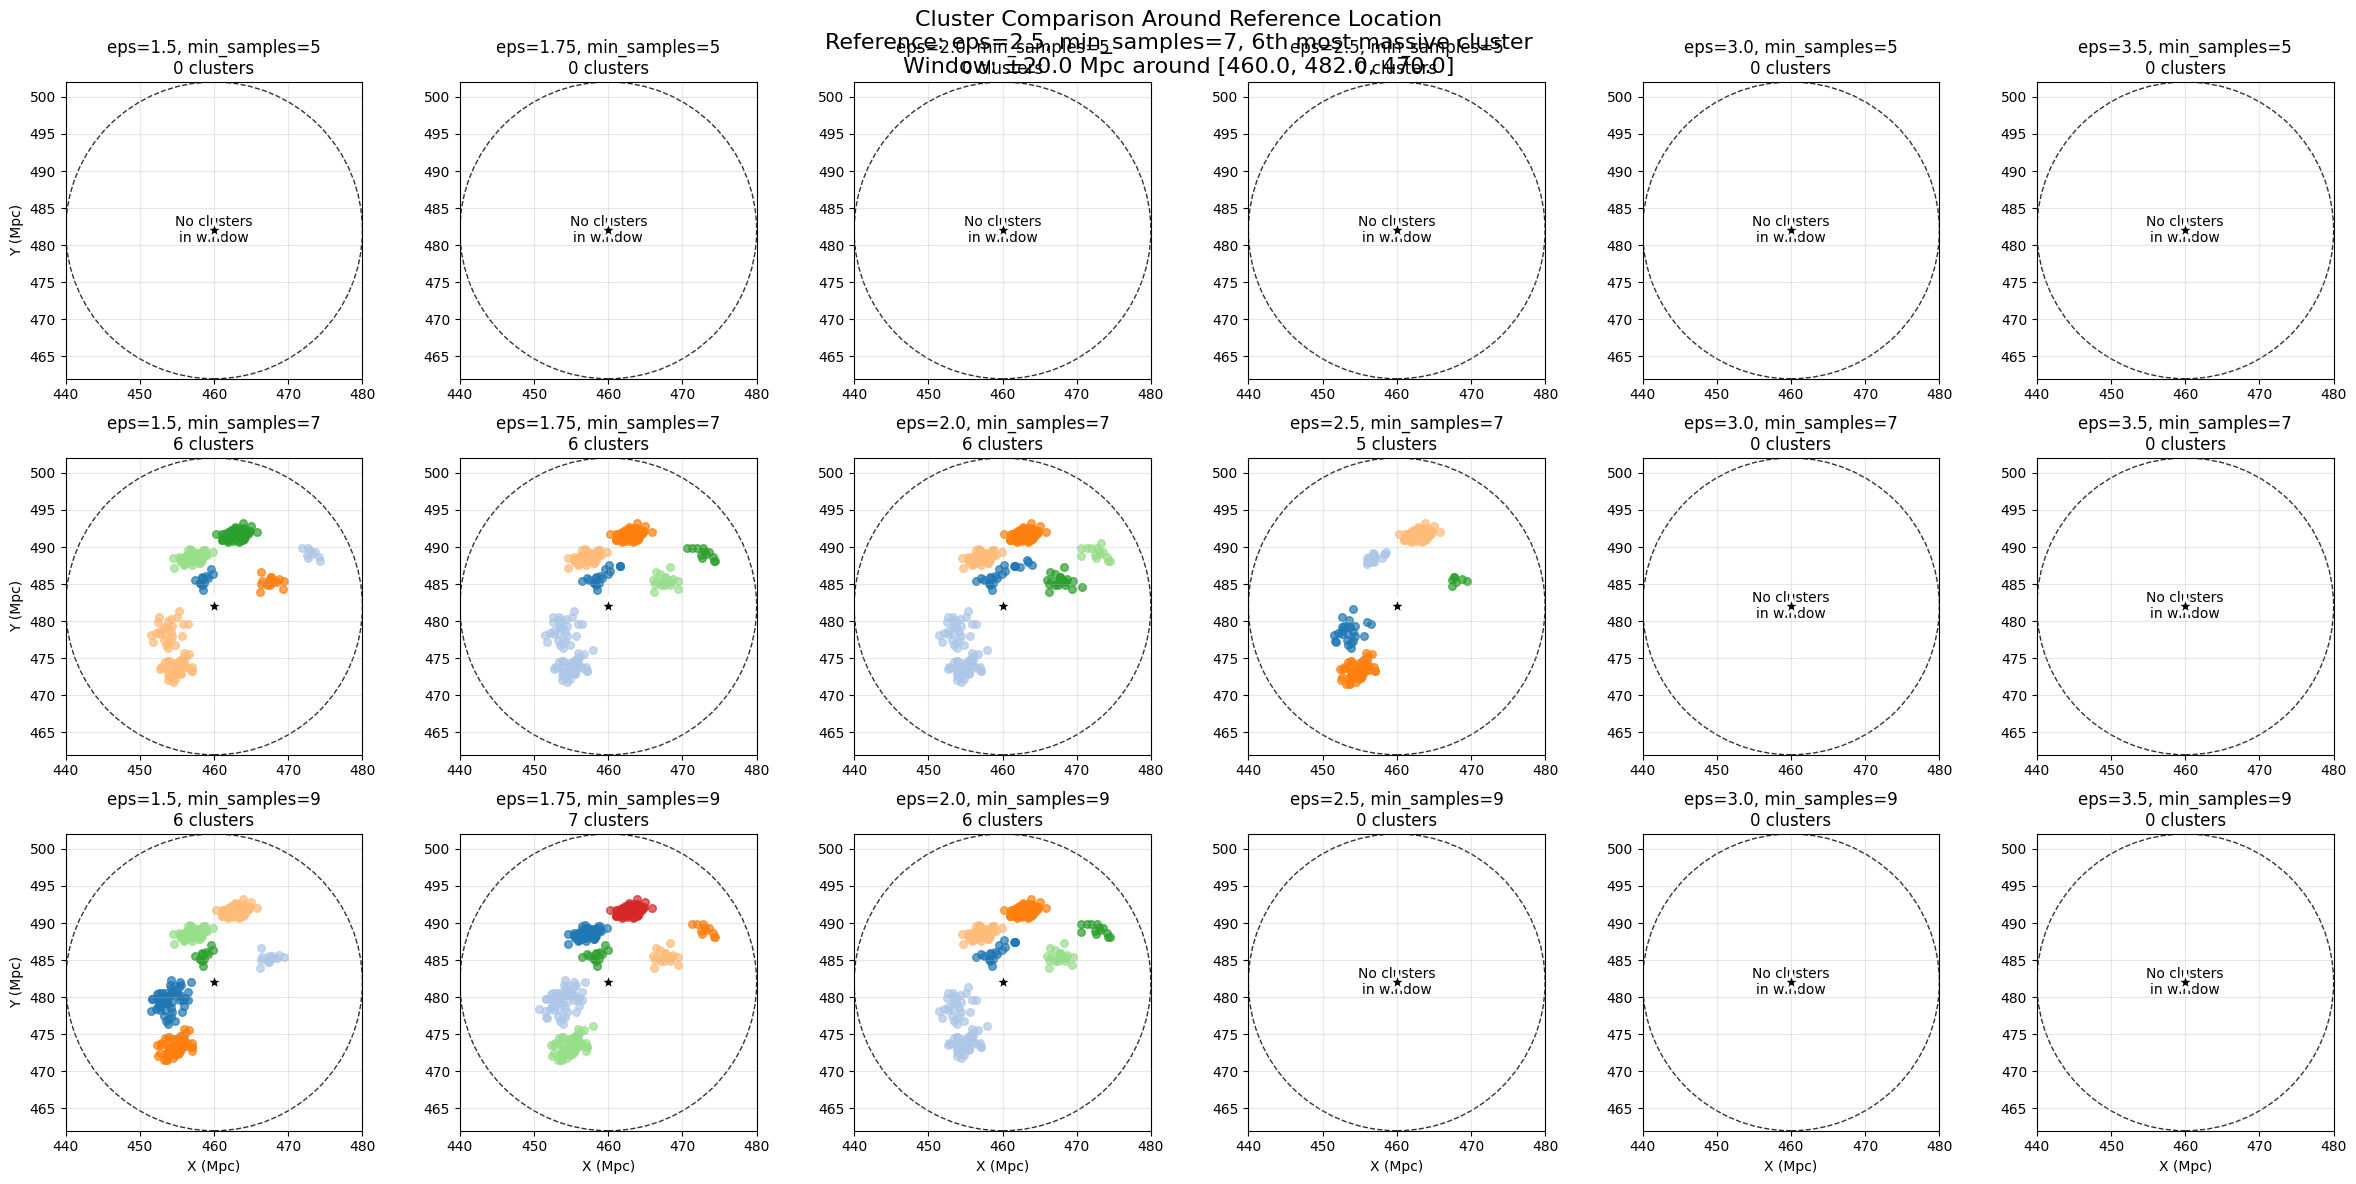

In [10]:
# Notebook Cell: Multi-Parameter Cluster Comparison Around Reference Location (Optimized)
import numpy as np
import matplotlib.pyplot as plt
from backend.utils import load_clusters_from_hdf5, find_clusters_in_window, load_single_cluster_members

# Configuration  
reference_eps = 2.5
reference_min_samples = 7
nth_most_massive = 6  # Select the Nth most massive cluster (1-indexed)
window_size = 20.0  # Mpc radius around centroid

# Load reference cluster data (minimal load to get centroids and masses only)
ref_eps_str = str(reference_eps).replace('.', 'p')
ref_filename = f"clusters_eps_{ref_eps_str}_min_samples_{reference_min_samples}.h5"
ref_clusters, ref_metadata = load_clusters_from_hdf5(OUTPUT_DIR, filename=ref_filename, minimal=True)

# Sort reference clusters by mean mass and select the Nth most massive
ref_clusters_sorted = sorted(ref_clusters, key=lambda x: x['mean_m200_mass'], reverse=True)
if nth_most_massive > len(ref_clusters_sorted):
    print(f"Only {len(ref_clusters_sorted)} clusters available, selecting the most massive")
    reference_cluster = ref_clusters_sorted[0]
else:
    reference_cluster = ref_clusters_sorted[nth_most_massive - 1]

reference_centroid = reference_cluster['mean_position']
reference_centroid = [460, 482, 470]
print(f"Reference cluster: ID {reference_cluster['cluster_id']}, mass {reference_cluster['mean_m200_mass']:.2e}")
print(f"Reference centroid: [{reference_centroid[0]:.1f}, {reference_centroid[1]:.1f}, {reference_centroid[2]:.1f}]")

# Define plot window
x_min, x_max = reference_centroid[0] - window_size, reference_centroid[0] + window_size
y_min, y_max = reference_centroid[1] - window_size, reference_centroid[1] + window_size

# Calculate subplot grid
n_eps = len(eps_values)
n_min_samples = len(min_samples_values)

# Create figure with appropriate size
fig_width = n_eps * 4
fig_height = n_min_samples * 4
fig, axes = plt.subplots(n_min_samples, n_eps, figsize=(fig_width, fig_height))
if n_min_samples == 1:
    axes = axes.reshape(1, -1)
if n_eps == 1:
    axes = axes.reshape(-1, 1)

# Plot for each parameter combination
for row_idx, min_samples in enumerate(min_samples_values):
    for col_idx, eps in enumerate(eps_values):
        ax = axes[row_idx, col_idx]
        
        # Generate filename for this parameter set
        eps_str = str(eps).replace('.', 'p')
        filename = f"clusters_eps_{eps_str}_min_samples_{min_samples}.h5"
        
        try:
            # Find clusters in window (metadata only)
            window_cluster_ids = find_clusters_in_window(OUTPUT_DIR, filename, 
                                                        reference_centroid, window_size)
            
            if len(window_cluster_ids) == 0:
                ax.text(0.5, 0.5, f'No clusters\nin window', 
                       transform=ax.transAxes, ha='center', va='center')
            else:
                # Load individual cluster members
                colors = plt.cm.tab20(np.linspace(0, 1, 20))
                if len(window_cluster_ids) > 20:
                    colors = plt.cm.gist_ncar(np.linspace(0, 1, len(window_cluster_ids)))
                
                for i, cluster_id in enumerate(window_cluster_ids):
                    cluster_data = load_single_cluster_members(OUTPUT_DIR, 
                                                             filename, cluster_id)
                    
                    if cluster_data is not None:
                        positions = cluster_data['member_data']['BoundSubhalo/CentreOfMass']
                        
                        # Filter positions to window
                        mask = ((positions[:, 0] >= x_min) & (positions[:, 0] <= x_max) & 
                               (positions[:, 1] >= y_min) & (positions[:, 1] <= y_max))
                        window_positions = positions[mask]
                        
                        if len(window_positions) > 0:
                            color = colors[i % len(colors)]
                            ax.scatter(window_positions[:, 0], window_positions[:, 1], 
                                     c=[color], s=30, alpha=0.7, 
                                     label=f'ID {cluster_id} (n={cluster_data["cluster_size"]})')
            
            # Mark reference centroid
            ax.scatter(reference_centroid[0], reference_centroid[1], 
                      c='black', s=200, marker='*', 
                      edgecolors='white', linewidth=2, zorder=10)
            
            # Add circle showing window boundary
            circle = plt.Circle((reference_centroid[0], reference_centroid[1]), 
                               window_size, fill=False, color='black', 
                               linestyle='--', linewidth=1, alpha=0.8)
            ax.add_patch(circle)
            
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
            ax.set_title(f'eps={eps}, min_samples={min_samples}\n{len(window_cluster_ids)} clusters')
            
            if row_idx == n_min_samples - 1:
                ax.set_xlabel('X (Mpc)')
            if col_idx == 0:
                ax.set_ylabel('Y (Mpc)')
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\neps={eps}\nmin_samples={min_samples}', 
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_aspect('equal')

plt.suptitle(f'Cluster Comparison Around Reference Location\n'
             f'Reference: eps={reference_eps}, min_samples={reference_min_samples}, '
             f'{nth_most_massive}{"st" if nth_most_massive==1 else "nd" if nth_most_massive==2 else "rd" if nth_most_massive==3 else "th"} most massive cluster\n'
             f'Window: ±{window_size} Mpc around [{reference_centroid[0]:.1f}, {reference_centroid[1]:.1f}, {reference_centroid[2]:.1f}]',
             fontsize=16, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Cluster occurence in random simulations

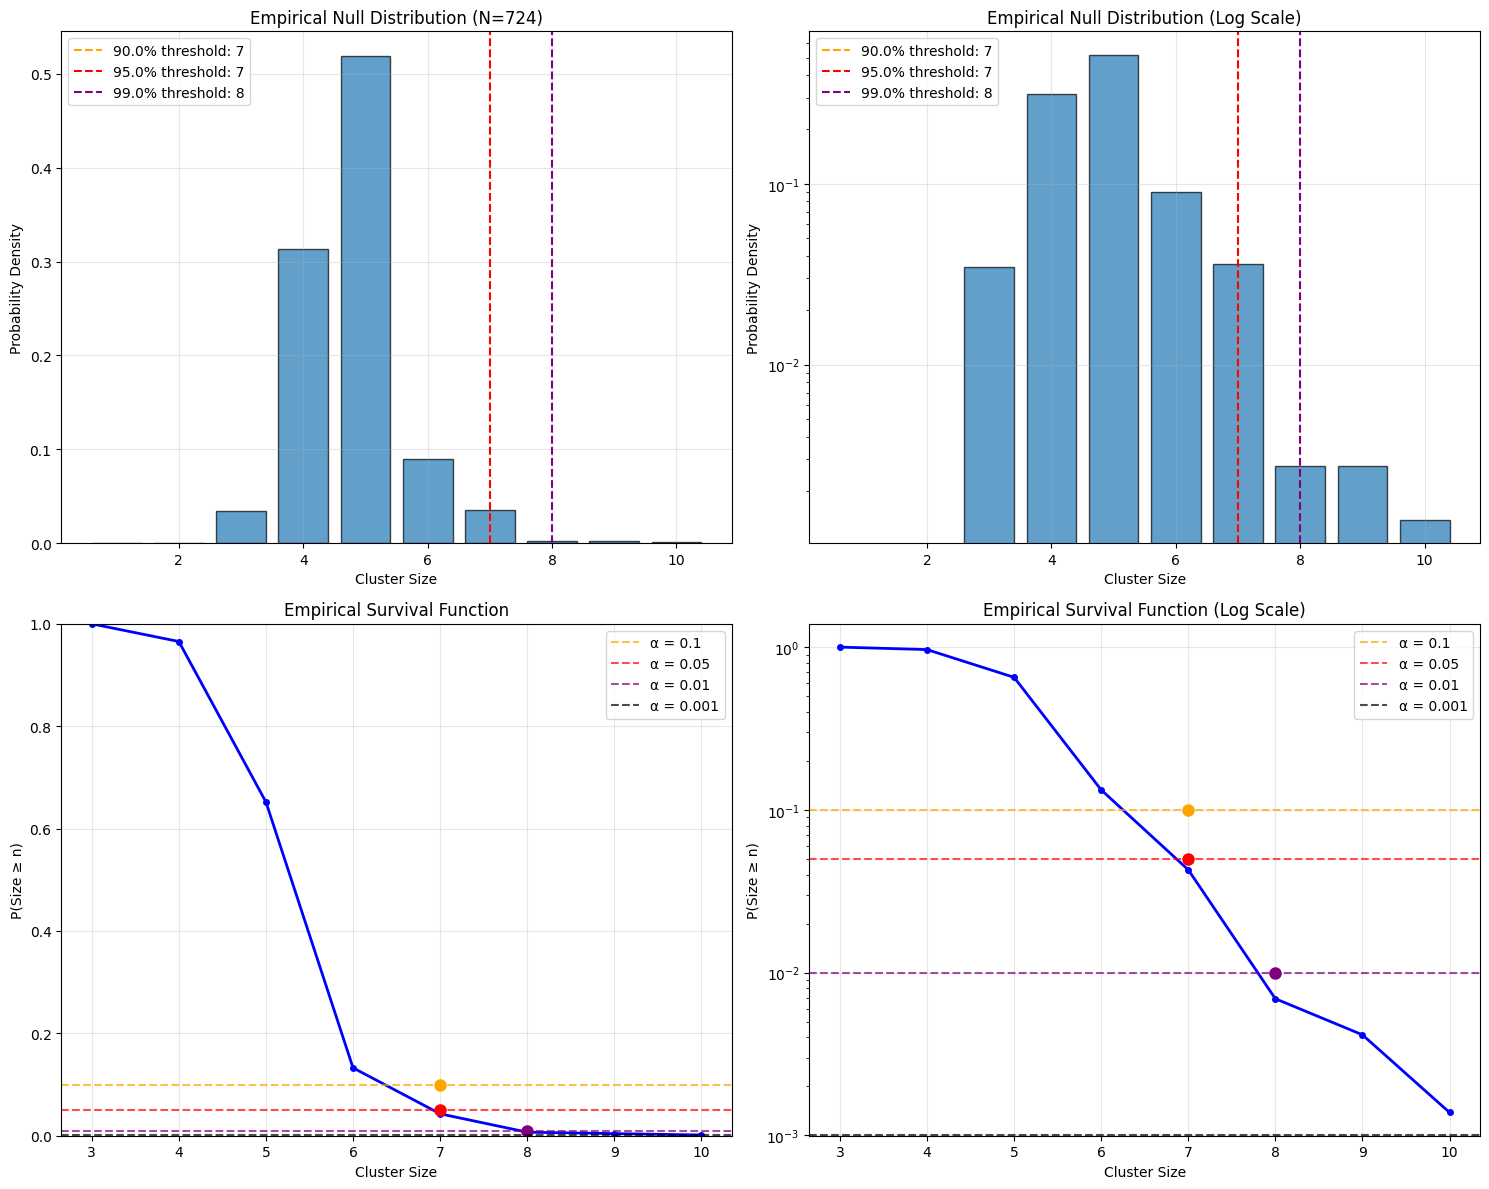

Null Distribution Summary:
Total clusters: 724
Size range: 3 - 10
Mean size: 4.81
Median size: 5.00

Significance Thresholds:
 90.0% confidence (α=0.100): size ≥  7 (p=0.0428, 31.0 expected)
 95.0% confidence (α=0.050): size ≥  7 (p=0.0428, 31.0 expected)
 99.0% confidence (α=0.010): size ≥  8 (p=0.0069, 5.0 expected)
 99.9% confidence (α=0.001): No threshold found

Tail Probabilities:
P(size ≥ 10) = 0.0014 (1.0 expected)


In [12]:
# empirical_null_analysis.py
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Load cluster sizes from HDF5 file
with h5py.File('../output/random_control_clusters.h5', 'r') as f:
    cluster_sizes = []
    clusters_grp = f['clusters']
    for cluster_name in clusters_grp.keys():
        cluster_sizes.append(clusters_grp[cluster_name].attrs['cluster_size'])

cluster_sizes = np.array(cluster_sizes)

# Empirical survival function: P(size >= n)
def empirical_survival(n):
    return np.mean(cluster_sizes >= n)

# Calculate significance thresholds
size_range = np.arange(3, max(cluster_sizes) + 1)
survival_probs = [empirical_survival(n) for n in size_range]

# Find thresholds for different significance levels
alpha_levels = [0.1, 0.05, 0.01, 0.001]
thresholds = {}

for alpha in alpha_levels:
    threshold_candidates = [n for n, p in zip(size_range, survival_probs) if p <= alpha]
    if threshold_candidates:
        thresholds[alpha] = min(threshold_candidates)
    else:
        thresholds[alpha] = None

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Empirical distribution (linear scale)
bins = np.arange(1, max(cluster_sizes) + 2) - 0.5
counts, _ = np.histogram(cluster_sizes, bins=bins, density=True)
bin_centers = np.arange(1, max(cluster_sizes) + 1)

ax1.bar(bin_centers, counts, alpha=0.7, edgecolor='black', width=0.8)
ax1.set_xlabel('Cluster Size')
ax1.set_ylabel('Probability Density')
ax1.set_title(f'Empirical Null Distribution (N={len(cluster_sizes)})')
ax1.grid(True, alpha=0.3)

# Add threshold lines
colors = ['orange', 'red', 'purple', 'black']
for i, (alpha, threshold) in enumerate(thresholds.items()):
    if threshold is not None:
        ax1.axvline(threshold, color=colors[i], linestyle='--', 
                   label=f'{(1-alpha)*100:.1f}% threshold: {threshold}')
ax1.legend()

# 2. Empirical distribution (log scale)
ax2.bar(bin_centers, counts, alpha=0.7, edgecolor='black', width=0.8)
ax2.set_xlabel('Cluster Size')
ax2.set_ylabel('Probability Density')
ax2.set_title('Empirical Null Distribution (Log Scale)')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Add threshold lines
for i, (alpha, threshold) in enumerate(thresholds.items()):
    if threshold is not None:
        ax2.axvline(threshold, color=colors[i], linestyle='--', 
                   label=f'{(1-alpha)*100:.1f}% threshold: {threshold}')
ax2.legend()

# 3. Survival function (linear scale)
ax3.plot(size_range, survival_probs, 'bo-', markersize=4, linewidth=2)
ax3.set_xlabel('Cluster Size')
ax3.set_ylabel('P(Size ≥ n)')
ax3.set_title('Empirical Survival Function')
ax3.grid(True, alpha=0.3)

# Add significance levels
for i, alpha in enumerate(alpha_levels):
    ax3.axhline(alpha, color=colors[i], linestyle='--', alpha=0.7,
               label=f'α = {alpha}')
    if thresholds[alpha] is not None:
        ax3.plot(thresholds[alpha], alpha, 'o', color=colors[i], markersize=8)

ax3.legend()
ax3.set_ylim(0, 1)

# 4. Survival function (log scale)
ax4.plot(size_range, survival_probs, 'bo-', markersize=4, linewidth=2)
ax4.set_xlabel('Cluster Size')
ax4.set_ylabel('P(Size ≥ n)')
ax4.set_title('Empirical Survival Function (Log Scale)')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

# Add significance levels
for i, alpha in enumerate(alpha_levels):
    ax4.axhline(alpha, color=colors[i], linestyle='--', alpha=0.7,
               label=f'α = {alpha}')
    if thresholds[alpha] is not None:
        ax4.plot(thresholds[alpha], alpha, 'o', color=colors[i], markersize=8)

ax4.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Null Distribution Summary:")
print(f"Total clusters: {len(cluster_sizes)}")
print(f"Size range: {min(cluster_sizes)} - {max(cluster_sizes)}")
print(f"Mean size: {np.mean(cluster_sizes):.2f}")
print(f"Median size: {np.median(cluster_sizes):.2f}")

print(f"\nSignificance Thresholds:")
for alpha in alpha_levels:
    if thresholds[alpha] is not None:
        confidence = (1 - alpha) * 100
        n_expected = empirical_survival(thresholds[alpha]) * len(cluster_sizes)
        print(f"{confidence:5.1f}% confidence (α={alpha:5.3f}): size ≥ {thresholds[alpha]:2d} "
              f"(p={empirical_survival(thresholds[alpha]):.4f}, {n_expected:.1f} expected)")
    else:
        print(f"{(1-alpha)*100:5.1f}% confidence (α={alpha:5.3f}): No threshold found")

# Detailed tail probabilities
print(f"\nTail Probabilities:")
for size in range(10, min(30, max(cluster_sizes) + 1), 5):
    prob = empirical_survival(size)
    expected = prob * len(cluster_sizes)
    print(f"P(size ≥ {size:2d}) = {prob:.4f} ({expected:.1f} expected)")